## Data Openning and Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

df = pd.read_hdf('/content/drive/MyDrive/audio_lyrics_combined.h5')
df.head()

song_audio song_lyrics Quadrant   AllMusic Id         Artist  \
0       A003        L053       Q3  MT0008469560  Stevie Wonder   
1       A005        L055       Q1  MT0005204984         Prince   
3       A010        L060       Q2  MT0031974477      Pearl Jam   
4       A013        L063       Q2  MT0002578360      The Clash   
6       A023        L073       Q2  MT0002558335     Papa Roach   

            Title                                             Genres  \
0          Lately                      Soul,Pop-Soul,Smooth Soul,R&B   
1  U Got the Look  Dance-Rock,R&B,Contemporary Pop/Rock,Contempor...   
3          Animal  Pop/Rock,Hard Rock,Alternative/Indie Rock,Alte...   
4  London Calling  Pop/Rock,New Wave,British Punk,Punk/New Wave,P...   
6     Last Resort             Alternative Metal,Pop/Rock,Heavy Metal   

                                              lyrics  \
0  Lately I have had the strangest feeling\nWith ...   
1  Here we are folks\nThe dream we all dream off\...   
3  One two three four five against one \nFive fiv...   
4  London calling to the faraway towns\nNow that ...   
6  Cut my life into pieces\nThis is my last resor...   

                                spectrogram_features  
0  [[-80.0, -80.0, -80.0, -80.0, -77.71686, -71.7...  
1  [[-80.0, -80.0, -69.585594, -48.468002, -38.08...  
3  [[-80.0, -79.827644, -59.335518, -55.471622, -...  
4  [[-80.0, -76.85271, -69.828865, -70.31357, -64...  
6  [[-24.160717, -27.344158, -28.813421, -28.3729...

Process Genres Column to make it usable for training

In [3]:
import numpy as np
import pandas as pd

# Define split_genres function (assuming it's not globally available after kernel restart)
def split_genres(genre_string):
    if isinstance(genre_string, str):
        return [genre.strip() for genre in genre_string.split(',')]
    return []

# Recalculate all_genres_list from the original 'Genres' column
all_genres_list_original = df['Genres'].apply(split_genres).explode()

# Recalculate genre_counts from the original genres
genre_counts = all_genres_list_original.value_counts()

# Now define top_10_genres_list
top_10_genres_list = genre_counts.head(10).index.tolist()

# Recalculate genres_list_of_lists from the original 'Genres' column
genres_list_of_lists = df['Genres'].apply(split_genres).tolist()

def select_top_genre_from_list(genres_for_song_list, top_genres_list):
    """
    Selects the first genre from genres_for_song_list that is present in top_genres_list.
    Returns None if no such genre is found.
    """
    if not isinstance(genres_for_song_list, list):
        return None # Handle cases where genre data might not be a list

    for genre in genres_for_song_list:
        if genre in top_genres_list:
            return genre
    return None

# Apply the function to the genres_list_of_lists
df['Genres'] = [select_top_genre_from_list(genre_list, top_10_genres_list) for genre_list in genres_list_of_lists]

print("DataFrame head with 'Genres' column updated to a single top 10 genre or None:")
display(df.head())
print("\nValue counts of the newly filtered 'Genres' column:")
print(df['Genres'].value_counts(dropna=False))

DataFrame head with 'Genres' column updated to a single top 10 genre or None:


song_audio song_lyrics Quadrant   AllMusic Id         Artist  \
0       A003        L053       Q3  MT0008469560  Stevie Wonder   
1       A005        L055       Q1  MT0005204984         Prince   
3       A010        L060       Q2  MT0031974477      Pearl Jam   
4       A013        L063       Q2  MT0002578360      The Clash   
6       A023        L073       Q2  MT0002558335     Papa Roach   

            Title    Genres  \
0          Lately       R&B   
1  U Got the Look       R&B   
3          Animal  Pop/Rock   
4  London Calling  Pop/Rock   
6     Last Resort  Pop/Rock   

                                              lyrics  \
0  Lately I have had the strangest feeling\nWith ...   
1  Here we are folks\nThe dream we all dream off\...   
3  One two three four five against one \nFive fiv...   
4  London calling to the faraway towns\nNow that ...   
6  Cut my life into pieces\nThis is my last resor...   

                                spectrogram_features  
0  [[-80.0, -80.0, -80.0, -80.0, -77.71686, -71.7...  
1  [[-80.0, -80.0, -69.585594, -48.468002, -38.08...  
3  [[-80.0, -79.827644, -59.335518, -55.471622, -...  
4  [[-80.0, -76.85271, -69.828865, -70.31357, -64...  
6  [[-24.160717, -27.344158, -28.813421, -28.3729...


Value counts of the newly filtered 'Genres' column:
Genres
Pop/Rock         757
Electronic       294
Country          255
Rap              165
Jazz             139
Blues            130
R&B              117
None              95
International     64
Folk              62
Vocal             47
Name: count, dtype: int64


In [4]:
# Remove rows where 'Genres' column is None
df.dropna(subset=['Genres'], inplace=True)

print("\nValue counts of 'Genres' column after removing None:")
print(df['Genres'].value_counts(dropna=False))


Value counts of 'Genres' column after removing None:
Genres
Pop/Rock         757
Electronic       294
Country          255
Rap              165
Jazz             139
Blues            130
R&B              117
International     64
Folk              62
Vocal             47
Name: count, dtype: int64


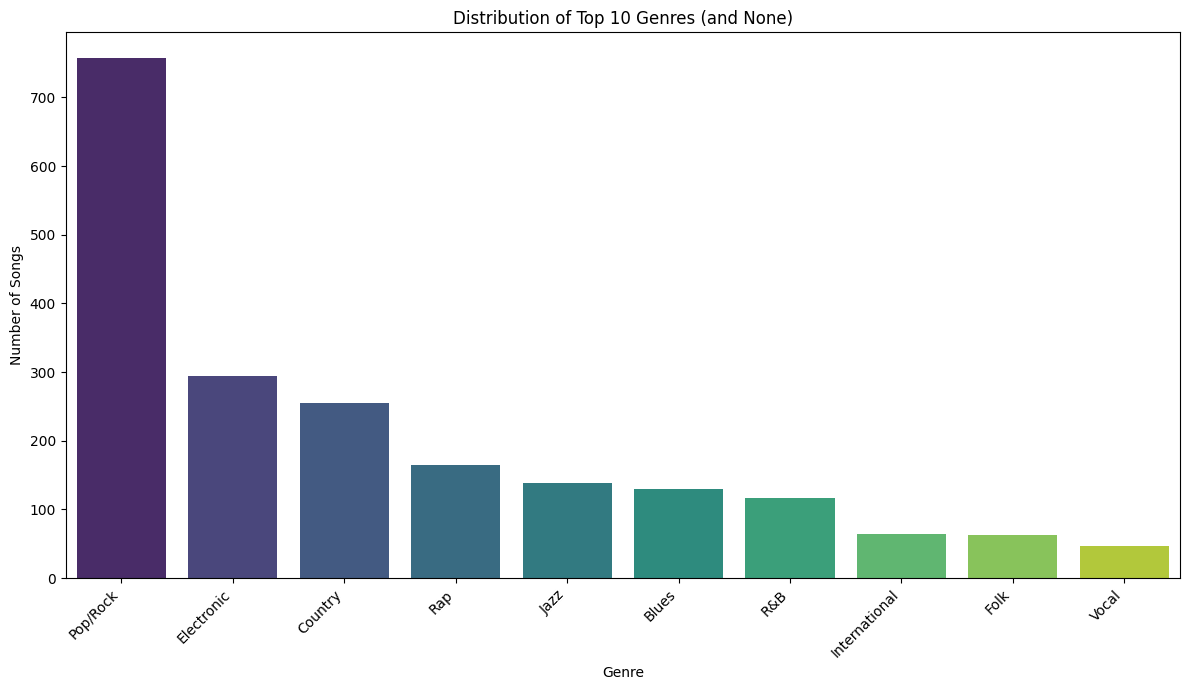

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the value counts of the 'Genres' column
genre_distribution = df['Genres'].value_counts()

plt.figure(figsize=(12, 7))
sns.barplot(x=genre_distribution.index, y=genre_distribution.values, palette='viridis', hue=genre_distribution.index, legend=False)

plt.title('Distribution of Top 10 Genres (and None)')
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [6]:
df.shape

(2030, 9)

Necessary Libraries

In [7]:
# Import all required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import Adam

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.manifold import TSNE

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu126


Data Preparation

In [8]:
# Prepare spectrogram data
# Initialize an empty list to store processed spectrograms
processed_spectrograms = []
TARGET_TIME = 256 # Define TARGET_TIME earlier for use in normalization/resizing

for i, spec_raw in enumerate(df['spectrogram_features'].values):
    # Normalize spectrogram (per-sample normalization)
    spec_normalized = (spec_raw - spec_raw.mean()) / (spec_raw.std() + 1e-8)

    # Resize spectrogram to fixed size for CNN (128, TARGET_TIME)
    current_time_dim = spec_normalized.shape[1]

    if current_time_dim > TARGET_TIME:
        # Downsample by taking every nth frame
        step = current_time_dim // TARGET_TIME
        resized_spec = spec_normalized[:, :TARGET_TIME * step:step][:, :TARGET_TIME]
    elif current_time_dim < TARGET_TIME:
        # Pad with zeros if shorter
        padding_needed = TARGET_TIME - current_time_dim
        resized_spec = np.pad(spec_normalized, ((0, 0), (0, padding_needed)), mode='constant')
    else:
        resized_spec = spec_normalized

    processed_spectrograms.append(resized_spec)

# Stack all processed spectrograms into a numpy array
spectrograms_resized = np.stack(processed_spectrograms)

print(f"Resized spectrograms shape: {spectrograms_resized.shape}")

Resized spectrograms shape: (2030, 128, 256)


In [9]:
# Prepare lyrics embeddings using TF-IDF
# Handle missing lyrics
lyrics_data = df['lyrics'].fillna('').values

# Create TF-IDF embeddings
tfidf_vectorizer = TfidfVectorizer(
    max_features=512,  # Limit vocabulary size
    stop_words='english',
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,
    max_df=0.95
)

lyrics_tfidf = tfidf_vectorizer.fit_transform(lyrics_data).toarray()
print(f"Lyrics TF-IDF shape: {lyrics_tfidf.shape}")

# Normalize lyrics features
lyrics_scaler = StandardScaler()
lyrics_normalized = lyrics_scaler.fit_transform(lyrics_tfidf)
print(f"Lyrics normalized shape: {lyrics_normalized.shape}")

Lyrics TF-IDF shape: (2030, 512)
Lyrics normalized shape: (2030, 512)


In [10]:
from sklearn.preprocessing import LabelEncoder

# Prepare 'Genres' as target labels (Label Encoding)
genre_label_encoder = LabelEncoder()
encoded_genres = genre_label_encoder.fit_transform(df['Genres'].values)

# Add the encoded genres to the DataFrame
df['encoded_genres'] = encoded_genres

print(f"Classes: {genre_label_encoder.classes_}")
print(f"Label distribution: {np.bincount(encoded_genres)}")
display(df.head())

Classes: ['Blues' 'Country' 'Electronic' 'Folk' 'International' 'Jazz' 'Pop/Rock'
 'R&B' 'Rap' 'Vocal']
Label distribution: [130 255 294  62  64 139 757 117 165  47]


song_audio song_lyrics Quadrant   AllMusic Id         Artist  \
0       A003        L053       Q3  MT0008469560  Stevie Wonder   
1       A005        L055       Q1  MT0005204984         Prince   
3       A010        L060       Q2  MT0031974477      Pearl Jam   
4       A013        L063       Q2  MT0002578360      The Clash   
6       A023        L073       Q2  MT0002558335     Papa Roach   

            Title    Genres  \
0          Lately       R&B   
1  U Got the Look       R&B   
3          Animal  Pop/Rock   
4  London Calling  Pop/Rock   
6     Last Resort  Pop/Rock   

                                              lyrics  \
0  Lately I have had the strangest feeling\nWith ...   
1  Here we are folks\nThe dream we all dream off\...   
3  One two three four five against one \nFive fiv...   
4  London calling to the faraway towns\nNow that ...   
6  Cut my life into pieces\nThis is my last resor...   

                                spectrogram_features  encoded_genres  
0  [[-80.0, -80.0, -80.0, -80.0, -77.71686, -71.7...               7  
1  [[-80.0, -80.0, -69.585594, -48.468002, -38.08...               7  
3  [[-80.0, -79.827644, -59.335518, -55.471622, -...               6  
4  [[-80.0, -76.85271, -69.828865, -70.31357, -64...               6  
6  [[-24.160717, -27.344158, -28.813421, -28.3729...               6

## Building Dataset

In [11]:
#MULTIMODAL DATASET PREPARATION

# Create one-hot encoded genre features
N_GENRES = len(genre_label_encoder.classes_)
genre_onehot = np.eye(N_GENRES)[encoded_genres]  # One-hot encode genres
print(f"Genre one-hot shape: {genre_onehot.shape}")

class MultimodalMusicDataset(Dataset):
    """Dataset combining audio spectrograms, lyrics embeddings, and genre information."""

    def __init__(self, spectrograms, lyrics, genre_onehot, genre_labels):
        self.spectrograms = torch.FloatTensor(spectrograms).unsqueeze(1)  # Add channel dim
        self.lyrics = torch.FloatTensor(lyrics)
        self.genre_onehot = torch.FloatTensor(genre_onehot)  # One-hot encoded genres as input
        self.genre_labels = torch.LongTensor(genre_labels)   # Original labels for evaluation

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        return {
            'spectrogram': self.spectrograms[idx],
            'lyrics': self.lyrics[idx],
            'genre_onehot': self.genre_onehot[idx],  # Input modality
            'genre': self.genre_labels[idx]          # For evaluation
        }

# Create dataset and dataloader
dataset = MultimodalMusicDataset(spectrograms_resized, lyrics_normalized, genre_onehot, encoded_genres)

# Split into train/val
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"\nDataset size: {len(dataset)}")
print(f"Train size: {train_size}, Val size: {val_size}")
print(f"Spectrogram shape: {dataset.spectrograms.shape}")
print(f"Lyrics shape: {dataset.lyrics.shape}")
print(f"Genre one-hot shape: {dataset.genre_onehot.shape}")
print(f"Number of genres: {N_GENRES}")

Genre one-hot shape: (2030, 10)

Dataset size: 2030
Train size: 1725, Val size: 305
Spectrogram shape: torch.Size([2030, 1, 128, 256])
Lyrics shape: torch.Size([2030, 512])
Genre one-hot shape: torch.Size([2030, 10])
Number of genres: 10


## Define Tri-Modal Beta-VAE

In [12]:
# BETA-VAE MODEL ARCHITECTURE (TRIMODAL: Audio + Lyrics + Genre)

class AudioEncoder(nn.Module):
    """CNN-based encoder for spectrograms."""

    def __init__(self, latent_dim=64):
        super(AudioEncoder, self).__init__()

        # Convolutional layers for spectrogram encoding
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (128, 256) -> (64, 128)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # -> (32, 64)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # -> (16, 32)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # -> (8, 16)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # -> (4, 8)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # Calculate flattened size: 512 * 4 * 8 = 16384
        self.flatten_size = 512 * 4 * 8

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_size, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        # Output dimension
        self.output_dim = 512

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class LyricsEncoder(nn.Module):
    """MLP-based encoder for lyrics TF-IDF embeddings."""

    def __init__(self, input_dim=512, hidden_dim=256, output_dim=256):
        super(LyricsEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, output_dim),
            nn.LeakyReLU(0.2)
        )

        self.output_dim = output_dim

    def forward(self, x):
        return self.encoder(x)


class GenreEncoder(nn.Module):
    """MLP-based encoder for genre one-hot vectors."""

    def __init__(self, n_genres, hidden_dim=64, output_dim=64):
        super(GenreEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(n_genres, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),

            nn.Linear(hidden_dim, output_dim),
            nn.LeakyReLU(0.2)
        )

        self.output_dim = output_dim

    def forward(self, x):
        return self.encoder(x)


class AudioDecoder(nn.Module):
    """CNN-based decoder for spectrograms."""

    def __init__(self, latent_dim=64):
        super(AudioDecoder, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512 * 4 * 8),
            nn.LeakyReLU(0.2)
        )

        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # -> (8, 16)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # -> (16, 32)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> (32, 64)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # -> (64, 128)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # -> (128, 256)
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 512, 4, 8)
        x = self.deconv_layers(x)
        return x


class LyricsDecoder(nn.Module):
    """MLP-based decoder for lyrics embeddings."""

    def __init__(self, latent_dim=64, hidden_dim=256, output_dim=512):
        super(LyricsDecoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, z):
        return self.decoder(z)


class GenreDecoder(nn.Module):
    """MLP-based decoder for genre reconstruction (outputs logits for classification)."""

    def __init__(self, latent_dim=64, hidden_dim=64, n_genres=10):
        super(GenreDecoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(hidden_dim, n_genres)
            # No softmax here - will use CrossEntropyLoss which includes it
        )

    def forward(self, z):
        return self.decoder(z)


class TrimodalBetaVAE(nn.Module):
    """
    Trimodal Beta-VAE combining audio, lyrics, AND genre for disentangled representations.
    All three modalities are used as input and reconstructed.
    """

    def __init__(self, lyrics_input_dim=512, n_genres=10, latent_dim=64, beta=4.0):
        super(TrimodalBetaVAE, self).__init__()

        self.latent_dim = latent_dim
        self.beta = beta
        self.n_genres = n_genres

        # Encoders for all three modalities
        self.audio_encoder = AudioEncoder(latent_dim)
        self.lyrics_encoder = LyricsEncoder(input_dim=lyrics_input_dim)
        self.genre_encoder = GenreEncoder(n_genres=n_genres)

        # Fusion layer (Audio: 512 + Lyrics: 256 + Genre: 64 = 832)
        fusion_input_dim = (self.audio_encoder.output_dim +
                           self.lyrics_encoder.output_dim +
                           self.genre_encoder.output_dim)

        self.fusion = nn.Sequential(
            nn.Linear(fusion_input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2)
        )

        # VAE latent space parameters
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoders for all three modalities
        self.audio_decoder = AudioDecoder(latent_dim)
        self.lyrics_decoder = LyricsDecoder(latent_dim, output_dim=lyrics_input_dim)
        self.genre_decoder = GenreDecoder(latent_dim, n_genres=n_genres)

    def encode(self, spectrogram, lyrics, genre_onehot):
        audio_feat = self.audio_encoder(spectrogram)
        lyrics_feat = self.lyrics_encoder(lyrics)
        genre_feat = self.genre_encoder(genre_onehot)

        # Concatenate all three modality features
        combined = torch.cat([audio_feat, lyrics_feat, genre_feat], dim=1)
        fused = self.fusion(combined)

        mu = self.fc_mu(fused)
        logvar = self.fc_logvar(fused)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        audio_recon = self.audio_decoder(z)
        lyrics_recon = self.lyrics_decoder(z)
        genre_logits = self.genre_decoder(z)  # Logits for genre classification
        return audio_recon, lyrics_recon, genre_logits

    def forward(self, spectrogram, lyrics, genre_onehot):
        mu, logvar = self.encode(spectrogram, lyrics, genre_onehot)
        z = self.reparameterize(mu, logvar)
        audio_recon, lyrics_recon, genre_logits = self.decode(z)
        return audio_recon, lyrics_recon, genre_logits, mu, logvar, z

    def get_latent(self, spectrogram, lyrics, genre_onehot):
        """Get latent representation without reparameterization (for inference)."""
        mu, logvar = self.encode(spectrogram, lyrics, genre_onehot)
        return mu


# Initialize model
LATENT_DIM = 64
BETA = 4.0
LYRICS_DIM = lyrics_normalized.shape[1]

model = TrimodalBetaVAE(
    lyrics_input_dim=LYRICS_DIM,
    n_genres=N_GENRES,
    latent_dim=LATENT_DIM,
    beta=BETA
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModalities: Audio (spectrogram) + Lyrics (TF-IDF) + Genre (one-hot)")
print(f"Latent dimension: {LATENT_DIM}")
print(f"Beta (disentanglement): {BETA}")
print(f"\nModel architecture:\n{model}")

Total parameters: 22,265,259
Trainable parameters: 22,265,259

Modalities: Audio (spectrogram) + Lyrics (TF-IDF) + Genre (one-hot)
Latent dimension: 64
Beta (disentanglement): 4.0

Model architecture:
TrimodalBetaVAE(
  (audio_encoder): AudioEncoder(
    (conv_layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2)
      (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10):

## Define Loss Function and Training Setup

In [13]:
# LOSS FUNCTIONS AND TRAINING (TRIMODAL)

def trimodal_beta_vae_loss(audio_recon, audio_orig, lyrics_recon, lyrics_orig,
                            genre_logits, genre_labels, mu, logvar, beta=4.0, genre_weight=1.0):
    """
    Trimodal Beta-VAE loss combining:
    - Audio reconstruction loss (MSE)
    - Lyrics reconstruction loss (MSE)
    - Genre classification loss (CrossEntropy)
    - KL divergence (weighted by beta)

    Args:
        beta: Weight for KL divergence term (beta > 1 encourages disentanglement)
        genre_weight: Weight for genre classification loss
    """
    # Audio reconstruction loss (MSE)
    audio_recon_loss = F.mse_loss(audio_recon, audio_orig, reduction='sum')

    # Lyrics reconstruction loss (MSE)
    lyrics_recon_loss = F.mse_loss(lyrics_recon, lyrics_orig, reduction='sum')

    # Genre classification loss (CrossEntropy)
    genre_loss = F.cross_entropy(genre_logits, genre_labels, reduction='sum')

    # Total reconstruction loss
    recon_loss = audio_recon_loss + lyrics_recon_loss + genre_weight * genre_loss

    # KL Divergence
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Beta-VAE loss
    total_loss = recon_loss + beta * kl_divergence

    return total_loss, recon_loss, kl_divergence, audio_recon_loss, lyrics_recon_loss, genre_loss


def train_epoch(model, train_loader, optimizer, device, beta):
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    total_genre_loss = 0
    correct_genres = 0
    total_samples = 0

    for batch in train_loader:
        spectrogram = batch['spectrogram'].to(device)
        lyrics = batch['lyrics'].to(device)
        genre_onehot = batch['genre_onehot'].to(device)
        genre_labels = batch['genre'].to(device)

        optimizer.zero_grad()

        audio_recon, lyrics_recon, genre_logits, mu, logvar, z = model(spectrogram, lyrics, genre_onehot)

        loss, recon, kl, audio_loss, lyrics_loss, genre_loss = trimodal_beta_vae_loss(
            audio_recon, spectrogram,
            lyrics_recon, lyrics,
            genre_logits, genre_labels,
            mu, logvar, beta
        )

        loss = loss / spectrogram.size(0)  # Normalize by batch size
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        total_recon += recon.item() / spectrogram.size(0)
        total_kl += kl.item() / spectrogram.size(0)
        total_genre_loss += genre_loss.item() / spectrogram.size(0)

        # Genre accuracy
        _, predicted = torch.max(genre_logits, 1)
        correct_genres += (predicted == genre_labels).sum().item()
        total_samples += genre_labels.size(0)

    n_batches = len(train_loader)
    genre_acc = correct_genres / total_samples
    return total_loss / n_batches, total_recon / n_batches, total_kl / n_batches, genre_acc


def validate(model, val_loader, device, beta):
    model.eval()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    correct_genres = 0
    total_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            spectrogram = batch['spectrogram'].to(device)
            lyrics = batch['lyrics'].to(device)
            genre_onehot = batch['genre_onehot'].to(device)
            genre_labels = batch['genre'].to(device)

            audio_recon, lyrics_recon, genre_logits, mu, logvar, z = model(spectrogram, lyrics, genre_onehot)

            loss, recon, kl, _, _, genre_loss = trimodal_beta_vae_loss(
                audio_recon, spectrogram,
                lyrics_recon, lyrics,
                genre_logits, genre_labels,
                mu, logvar, beta
            )

            loss = loss / spectrogram.size(0)

            total_loss += loss.item()
            total_recon += recon.item() / spectrogram.size(0)
            total_kl += kl.item() / spectrogram.size(0)

            # Genre accuracy
            _, predicted = torch.max(genre_logits, 1)
            correct_genres += (predicted == genre_labels).sum().item()
            total_samples += genre_labels.size(0)

    n_batches = len(val_loader)
    genre_acc = correct_genres / total_samples
    return total_loss / n_batches, total_recon / n_batches, total_kl / n_batches, genre_acc


print("Trimodal loss functions and training utilities defined.")
print("Loss = Audio_MSE + Lyrics_MSE + Genre_CrossEntropy + β × KL_Divergence")

Trimodal loss functions and training utilities defined.
Loss = Audio_MSE + Lyrics_MSE + Genre_CrossEntropy + β × KL_Divergence


## Training

In [14]:
# TRAIN TRIMODAL BETA-VAE MODEL

# Training configuration
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training history
history = {
    'train_loss': [], 'train_recon': [], 'train_kl': [], 'train_genre_acc': [],
    'val_loss': [], 'val_recon': [], 'val_kl': [], 'val_genre_acc': []
}

best_val_loss = float('inf')
best_model_state = None

print(f"Training Trimodal Beta-VAE with beta={BETA}, latent_dim={LATENT_DIM}")
print(f"Modalities: Audio + Lyrics + Genre")
print(f"Epochs: {NUM_EPOCHS}, LR: {LEARNING_RATE}")
print("-" * 60)

for epoch in tqdm(range(NUM_EPOCHS), desc="Training"):
    # Train
    train_loss, train_recon, train_kl, train_genre_acc = train_epoch(model, train_loader, optimizer, device, BETA)

    # Validate
    val_loss, val_recon, val_kl, val_genre_acc = validate(model, val_loader, device, BETA)

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_recon'].append(train_recon)
    history['train_kl'].append(train_kl)
    history['train_genre_acc'].append(train_genre_acc)
    history['val_loss'].append(val_loss)
    history['val_recon'].append(val_recon)
    history['val_kl'].append(val_kl)
    history['val_genre_acc'].append(val_genre_acc)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"  Train - Loss: {train_loss:.4f}, Recon: {train_recon:.4f}, KL: {train_kl:.4f}, Genre Acc: {train_genre_acc:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Recon: {val_recon:.4f}, KL: {val_kl:.4f}, Genre Acc: {val_genre_acc:.4f}")


# Load best model
model.load_state_dict(best_model_state)
print(f"\nTraining complete! Best validation loss: {best_val_loss:.4f}")

Training Trimodal Beta-VAE with beta=4.0, latent_dim=64
Modalities: Audio + Lyrics + Genre
Epochs: 50, LR: 0.0001
------------------------------------------------------------


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/50
  Train - Loss: 15104.5294, Recon: 14947.3046, KL: 39.3062, Genre Acc: 0.3526
  Val   - Loss: 15350.0621, Recon: 15216.9942, KL: 33.2670, Genre Acc: 0.3869
Epoch 20/50
  Train - Loss: 14782.9017, Recon: 14596.7044, KL: 46.5493, Genre Acc: 0.3815
  Val   - Loss: 15047.7379, Recon: 14890.8610, KL: 39.2193, Genre Acc: 0.4000
Epoch 30/50
  Train - Loss: 14593.1593, Recon: 14395.5284, KL: 49.4077, Genre Acc: 0.3874
  Val   - Loss: 14941.9819, Recon: 14771.7527, KL: 42.5573, Genre Acc: 0.3967
Epoch 40/50
  Train - Loss: 14457.5983, Recon: 14251.8089, KL: 51.4474, Genre Acc: 0.4062
  Val   - Loss: 14898.9265, Recon: 14708.4371, KL: 47.6223, Genre Acc: 0.3705
Epoch 50/50
  Train - Loss: 14275.9900, Recon: 14055.2245, KL: 55.1914, Genre Acc: 0.3980
  Val   - Loss: 14870.8999, Recon: 14669.8039, KL: 50.2740, Genre Acc: 0.4033

Training complete! Best validation loss: 14857.9963


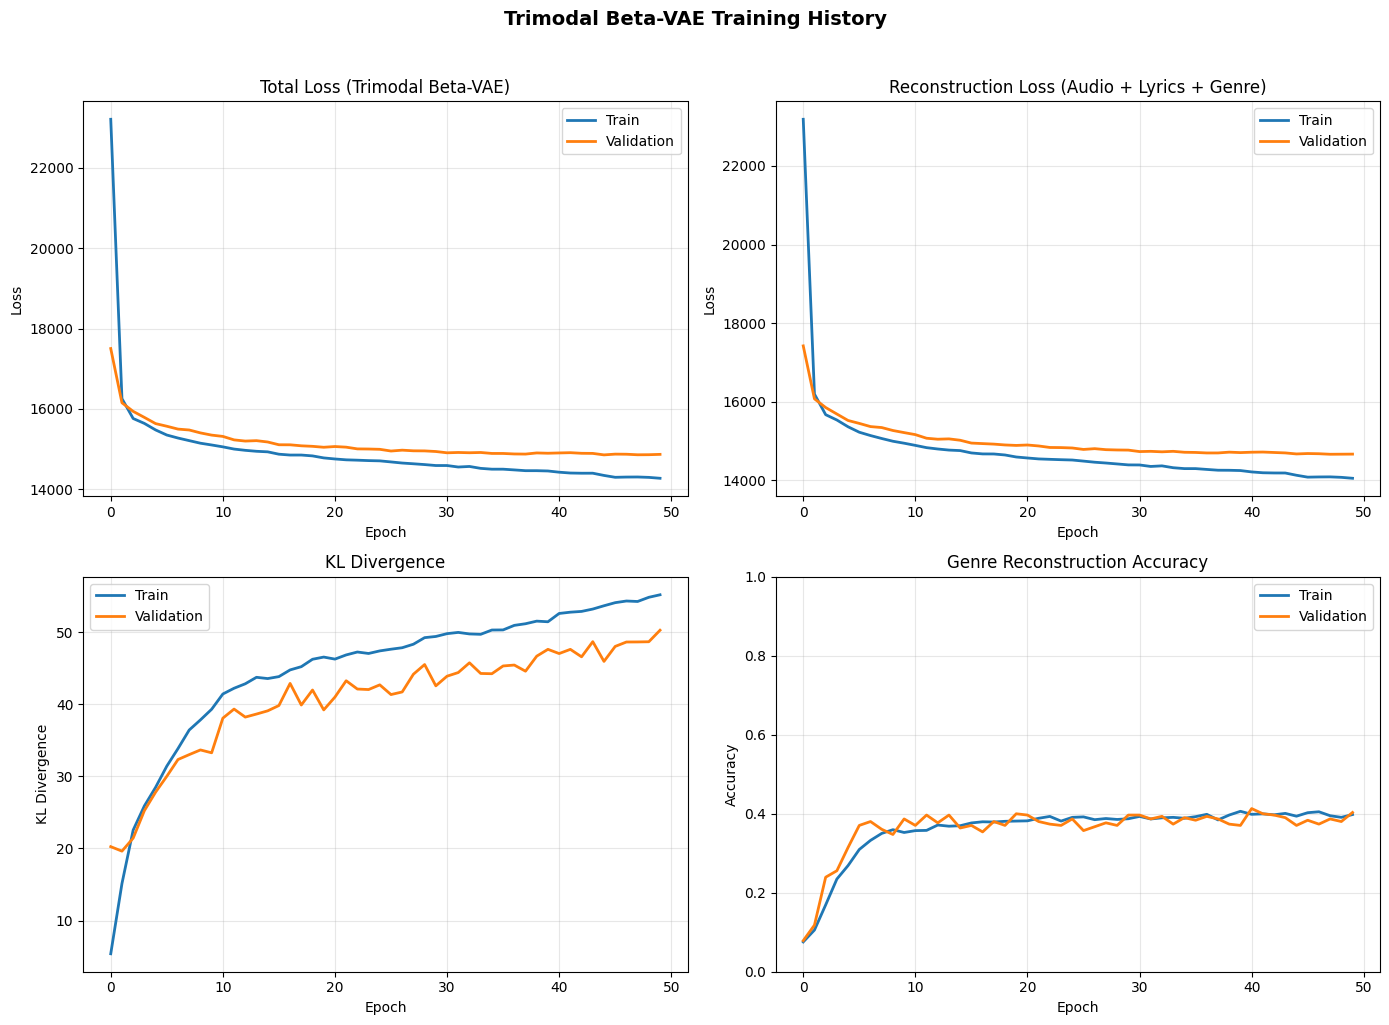


Final Genre Reconstruction Accuracy: Train=0.3980, Val=0.4033


In [15]:
# 5. PLOT TRAINING HISTORY

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total Loss
axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Total Loss (Trimodal Beta-VAE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Reconstruction Loss
axes[0, 1].plot(history['train_recon'], label='Train', linewidth=2)
axes[0, 1].plot(history['val_recon'], label='Validation', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Reconstruction Loss (Audio + Lyrics + Genre)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# KL Divergence
axes[1, 0].plot(history['train_kl'], label='Train', linewidth=2)
axes[1, 0].plot(history['val_kl'], label='Validation', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('KL Divergence')
axes[1, 0].set_title('KL Divergence')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Genre Accuracy
axes[1, 1].plot(history['train_genre_acc'], label='Train', linewidth=2)
axes[1, 1].plot(history['val_genre_acc'], label='Validation', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Genre Reconstruction Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(0, 1)

plt.suptitle('Trimodal Beta-VAE Training History', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nFinal Genre Reconstruction Accuracy: Train={history['train_genre_acc'][-1]:.4f}, Val={history['val_genre_acc'][-1]:.4f}")

## Feature Extraction and Clustering on Latent Representations

In [16]:
# EXTRACT LATENT REPRESENTATIONS

def extract_all_latents(model, dataset, device, batch_size=64):
    """Extract latent representations for the entire dataset."""
    model.eval()

    # Create a dataloader for the full dataset
    full_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_latents = []
    all_genres = []

    with torch.no_grad():
        for batch in tqdm(full_loader, desc="Extracting latents"):
            spectrogram = batch['spectrogram'].to(device)
            lyrics = batch['lyrics'].to(device)
            genre_onehot = batch['genre_onehot'].to(device)
            genres = batch['genre']

            # Get latent representations (mean of the distribution)
            latent = model.get_latent(spectrogram, lyrics, genre_onehot)

            all_latents.append(latent.cpu().numpy())
            all_genres.append(genres.numpy())

    latents = np.vstack(all_latents)
    genres = np.concatenate(all_genres)

    return latents, genres

# Extract latents for the full dataset
latent_representations, genre_labels = extract_all_latents(model, dataset, device)
print(f"Latent representations shape: {latent_representations.shape}")
print(f"Genre labels shape: {genre_labels.shape}")
print(f"\nLatent space now encodes information from all 3 modalities: Audio + Lyrics + Genre")

Extracting latents:   0%|          | 0/32 [00:00<?, ?it/s]

Latent representations shape: (2030, 64)
Genre labels shape: (2030,)

Latent space now encodes information from all 3 modalities: Audio + Lyrics + Genre


In [17]:
# CLUSTERING EVALUATION METRICS

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score
from scipy.stats import mode
from scipy.optimize import linear_sum_assignment

def cluster_purity(y_true, y_pred):
    """
    Calculate cluster purity score.
    """
    contingency_matrix = np.zeros((len(np.unique(y_pred)), len(np.unique(y_true))))

    for i, cluster_id in enumerate(np.unique(y_pred)):
        cluster_mask = y_pred == cluster_id
        for j, class_id in enumerate(np.unique(y_true)):
            contingency_matrix[i, j] = np.sum((y_pred == cluster_id) & (y_true == class_id))

    # Sum of max elements in each row
    purity = np.sum(np.max(contingency_matrix, axis=1)) / len(y_true)
    return purity


def evaluate_clustering(latents, true_labels, cluster_labels, method_name=""):
    """
    Comprehensive clustering evaluation.
    """
    results = {}

    # Silhouette Score
    if len(np.unique(cluster_labels)) > 1:
        results['silhouette'] = silhouette_score(latents, cluster_labels)
    else:
        results['silhouette'] = -1

    # Normalized Mutual Information
    results['nmi'] = normalized_mutual_info_score(true_labels, cluster_labels)

    # Adjusted Rand Index
    results['ari'] = adjusted_rand_score(true_labels, cluster_labels)

    # Cluster Purity
    results['purity'] = cluster_purity(true_labels, cluster_labels)

    # Davies-Bouldin Index (lower is better)
    if len(np.unique(cluster_labels)) > 1:
        results['davies_bouldin'] = davies_bouldin_score(latents, cluster_labels)
    else:
        results['davies_bouldin'] = float('inf')

    print(f"Clustering Results: {method_name}\n\n")
    print(f"Silhouette Score:      {results['silhouette']:.4f}")
    print(f"Normalized MI:         {results['nmi']:.4f}")
    print(f"Adjusted Rand Index:   {results['ari']:.4f}")
    print(f"Cluster Purity:        {results['purity']:.4f}")
    print(f"Davies-Bouldin Index:  {results['davies_bouldin']:.4f}")

    return results


print("Clustering evaluation metrics defined.")

Clustering evaluation metrics defined.


In [18]:
# BETA-VAE CLUSTERING (K-MEANS ON LATENT SPACE)

n_clusters = len(genre_label_encoder.classes_)
print(f"Number of clusters (genres): {n_clusters}")

# K-Means on Beta-VAE latent space
kmeans_vae = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
vae_cluster_labels = kmeans_vae.fit_predict(latent_representations)

# Evaluate
vae_results = evaluate_clustering(
    latent_representations,
    genre_labels,
    vae_cluster_labels,
    "Beta-VAE + K-Means"
)

Number of clusters (genres): 10
Clustering Results: Beta-VAE + K-Means


Silhouette Score:      0.0528
Normalized MI:         0.0802
Adjusted Rand Index:   0.0258
Cluster Purity:        0.3729
Davies-Bouldin Index:  2.7134


## Baselines(PCA+K-means, Autoencoder+K-means and Direct Spectral Feature Clustering)

In [19]:
# BASELINE 1: PCA + K-MEANS

# Combine audio and lyrics features for baseline
spectrograms_flat = spectrograms_resized.reshape(spectrograms_resized.shape[0], -1)
combined_features = np.hstack([spectrograms_flat, lyrics_normalized])
print(f"Combined features shape: {combined_features.shape}")

# Standardize features
scaler_baseline = StandardScaler()
combined_scaled = scaler_baseline.fit_transform(combined_features)

# Apply PCA (reduce to same dimension as latent space for fair comparison)
pca = PCA(n_components=LATENT_DIM, random_state=42)
pca_features = pca.fit_transform(combined_scaled)
print(f"PCA features shape: {pca_features.shape}")
print(f"PCA explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f}")

# K-Means on PCA features
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
pca_cluster_labels = kmeans_pca.fit_predict(pca_features)

# Evaluate
pca_results = evaluate_clustering(
    pca_features,
    genre_labels,
    pca_cluster_labels,
    "PCA + K-Means"
)

Combined features shape: (2030, 33280)
PCA features shape: (2030, 64)
PCA explained variance ratio: 0.3813
Clustering Results: PCA + K-Means


Silhouette Score:      0.0654
Normalized MI:         0.1066
Adjusted Rand Index:   0.0366
Cluster Purity:        0.3764
Davies-Bouldin Index:  2.9038


In [20]:
# BASELINE 2: STANDARD AUTOENCODER + K-MEANS

class StandardAutoencoder(nn.Module):
    """Standard Autoencoder (no variational component) for comparison."""

    def __init__(self, input_dim, latent_dim=64):
        super(StandardAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z

    def get_latent(self, x):
        return self.encoder(x)


# Train Standard Autoencoder
ae_input_dim = combined_scaled.shape[1]
autoencoder = StandardAutoencoder(ae_input_dim, LATENT_DIM).to(device)

# Prepare data
ae_dataset = TensorDataset(torch.FloatTensor(combined_scaled))
ae_train_size = int(0.85 * len(ae_dataset))
ae_val_size = len(ae_dataset) - ae_train_size
ae_train_dataset, ae_val_dataset = torch.utils.data.random_split(ae_dataset, [ae_train_size, ae_val_size])

ae_train_loader = DataLoader(ae_train_dataset, batch_size=64, shuffle=True)
ae_val_loader = DataLoader(ae_val_dataset, batch_size=64, shuffle=False)

ae_optimizer = Adam(autoencoder.parameters(), lr=1e-4, weight_decay=1e-5)
ae_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(ae_optimizer, mode='min', factor=0.5, patience=5)

ae_history = {'train_loss': [], 'val_loss': []}
best_ae_loss = float('inf')

print("Training Standard Autoencoder...")
for epoch in tqdm(range(50), desc="AE Training"):
    # Train
    autoencoder.train()
    train_loss = 0
    for batch in ae_train_loader:
        x = batch[0].to(device)
        ae_optimizer.zero_grad()
        recon, _ = autoencoder(x)
        loss = F.mse_loss(recon, x)
        loss.backward()
        ae_optimizer.step()
        train_loss += loss.item()

    # Validate
    autoencoder.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in ae_val_loader:
            x = batch[0].to(device)
            recon, _ = autoencoder(x)
            val_loss += F.mse_loss(recon, x).item()

    train_loss /= len(ae_train_loader)
    val_loss /= len(ae_val_loader)
    ae_history['train_loss'].append(train_loss)
    ae_history['val_loss'].append(val_loss)

    ae_scheduler.step(val_loss)

    if val_loss < best_ae_loss:
        best_ae_loss = val_loss
        best_ae_state = autoencoder.state_dict().copy()

autoencoder.load_state_dict(best_ae_state)
print(f"Autoencoder training complete. Best val loss: {best_ae_loss:.4f}")

# Extract AE latent features
autoencoder.eval()
with torch.no_grad():
    ae_latents = autoencoder.get_latent(torch.FloatTensor(combined_scaled).to(device)).cpu().numpy()

# K-Means on AE latent space
kmeans_ae = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
ae_cluster_labels = kmeans_ae.fit_predict(ae_latents)

# Evaluate
ae_results = evaluate_clustering(
    ae_latents,
    genre_labels,
    ae_cluster_labels,
    "Autoencoder + K-Means"
)

Training Standard Autoencoder...


AE Training:   0%|          | 0/50 [00:00<?, ?it/s]

Autoencoder training complete. Best val loss: 0.7694
Clustering Results: Autoencoder + K-Means


Silhouette Score:      0.0791
Normalized MI:         0.1102
Adjusted Rand Index:   0.0410
Cluster Purity:        0.3783
Davies-Bouldin Index:  2.3962


In [21]:

# BASELINE 3: DIRECT SPECTRAL FEATURE CLUSTERING

# Use only spectral (audio) features
spectrograms_flat_scaled = StandardScaler().fit_transform(spectrograms_flat)

# Reduce dimensionality for clustering
pca_spectral = PCA(n_components=min(LATENT_DIM, spectrograms_flat_scaled.shape[1]), random_state=42)
spectral_pca = pca_spectral.fit_transform(spectrograms_flat_scaled)

# K-Means on spectral features
kmeans_spectral = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
spectral_cluster_labels = kmeans_spectral.fit_predict(spectral_pca)

# Evaluate
spectral_results = evaluate_clustering(
    spectral_pca,
    genre_labels,
    spectral_cluster_labels,
    "Direct Spectral Features + K-Means"
)

Clustering Results: Direct Spectral Features + K-Means


Silhouette Score:      0.0655
Normalized MI:         0.1066
Adjusted Rand Index:   0.0365
Cluster Purity:        0.3764
Davies-Bouldin Index:  2.9052


## Comparing Models

In [22]:
# COMPARISON SUMMARY TABLE

# Compile all results
comparison_data = {
    'Method': ['Beta-VAE + K-Means', 'PCA + K-Means', 'Autoencoder + K-Means', 'Spectral Features + K-Means'],
    'Silhouette': [vae_results['silhouette'], pca_results['silhouette'], ae_results['silhouette'], spectral_results['silhouette']],
    'NMI': [vae_results['nmi'], pca_results['nmi'], ae_results['nmi'], spectral_results['nmi']],
    'ARI': [vae_results['ari'], pca_results['ari'], ae_results['ari'], spectral_results['ari']],
    'Purity': [vae_results['purity'], pca_results['purity'], ae_results['purity'], spectral_results['purity']],
    'Davies-Bouldin': [vae_results['davies_bouldin'], pca_results['davies_bouldin'], ae_results['davies_bouldin'], spectral_results['davies_bouldin']]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("CLUSTERING METHODS COMPARISON")
display(comparison_df)

CLUSTERING METHODS COMPARISON


Method  Silhouette     NMI     ARI  Purity  \
0           Beta-VAE + K-Means      0.0528  0.0802  0.0258  0.3729   
1                PCA + K-Means      0.0654  0.1066  0.0366  0.3764   
2        Autoencoder + K-Means      0.0791  0.1102  0.0410  0.3783   
3  Spectral Features + K-Means      0.0655  0.1066  0.0365  0.3764   

   Davies-Bouldin  
0          2.7134  
1          2.9038  
2          2.3962  
3          2.9052

## Visualization

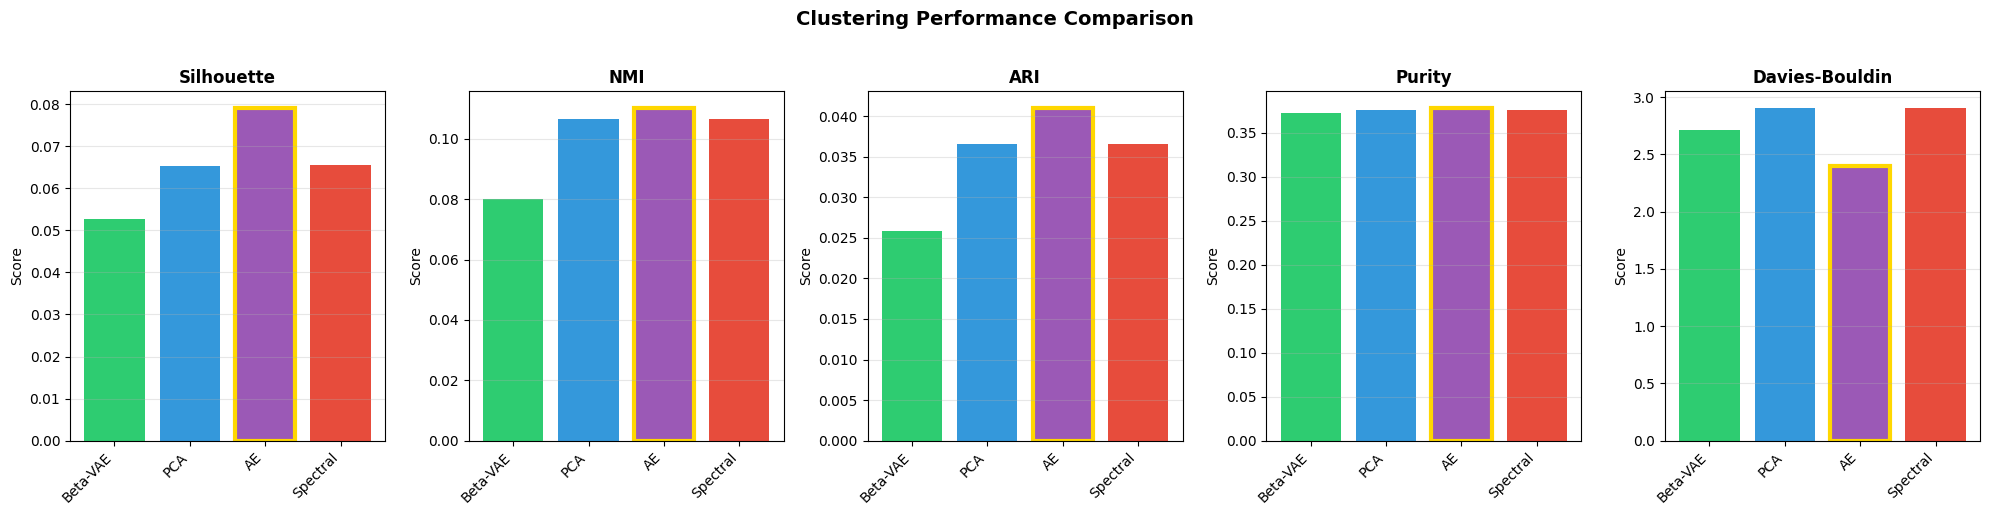

In [23]:

# VISUALIZATION: COMPARISON BAR CHART

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
metrics = ['Silhouette', 'NMI', 'ARI', 'Purity', 'Davies-Bouldin']
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']

for i, metric in enumerate(metrics):
    values = comparison_df[metric].values
    bars = axes[i].bar(range(len(comparison_df)), values, color=colors)
    axes[i].set_xticks(range(len(comparison_df)))
    axes[i].set_xticklabels(['Beta-VAE', 'PCA', 'AE', 'Spectral'], rotation=45, ha='right')
    axes[i].set_title(metric, fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Score')
    axes[i].grid(True, alpha=0.3, axis='y')

    # Highlight best
    if metric == 'Davies-Bouldin':
        best_idx = np.argmin(values)
    else:
        best_idx = np.argmax(values)
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)

plt.suptitle('Clustering Performance Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

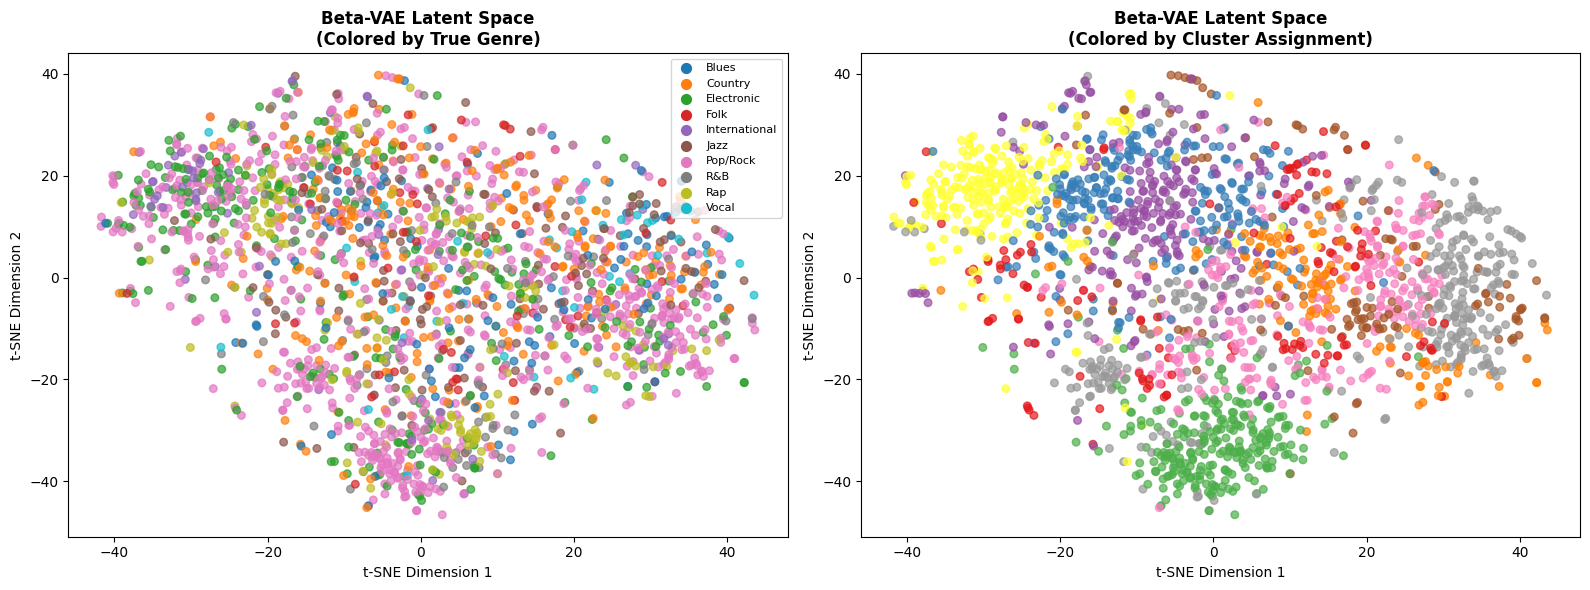

In [24]:
# VISUALIZATION: LATENT SPACE (t-SNE)

def plot_latent_space_tsne(latents, labels, label_names, title, cluster_labels=None):
    """Visualize latent space using t-SNE."""

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(latents)-1))
    latents_2d = tsne.fit_transform(latents)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Colored by true genre labels
    scatter1 = axes[0].scatter(
        latents_2d[:, 0], latents_2d[:, 1],
        c=labels, cmap='tab10', alpha=0.7, s=30
    )
    axes[0].set_title(f'{title}\n(Colored by True Genre)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('t-SNE Dimension 1')
    axes[0].set_ylabel('t-SNE Dimension 2')

    # Add legend
    unique_labels = np.unique(labels)
    handles = [plt.scatter([], [], c=plt.cm.tab10(l / len(unique_labels)), s=50, label=label_names[l])
               for l in unique_labels]
    axes[0].legend(handles=handles, labels=[label_names[l] for l in unique_labels],
                   loc='upper right', fontsize=8, markerscale=1)

    # Plot 2: Colored by cluster assignments
    if cluster_labels is not None:
        scatter2 = axes[1].scatter(
            latents_2d[:, 0], latents_2d[:, 1],
            c=cluster_labels, cmap='Set1', alpha=0.7, s=30
        )
        axes[1].set_title(f'{title}\n(Colored by Cluster Assignment)', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('t-SNE Dimension 1')
        axes[1].set_ylabel('t-SNE Dimension 2')

    plt.tight_layout()
    plt.show()

    return latents_2d

# Visualize Beta-VAE latent space
genre_names = genre_label_encoder.classes_
vae_tsne = plot_latent_space_tsne(
    latent_representations,
    genre_labels,
    genre_names,
    'Beta-VAE Latent Space',
    vae_cluster_labels
)

Generating t-SNE visualizations for all methods...


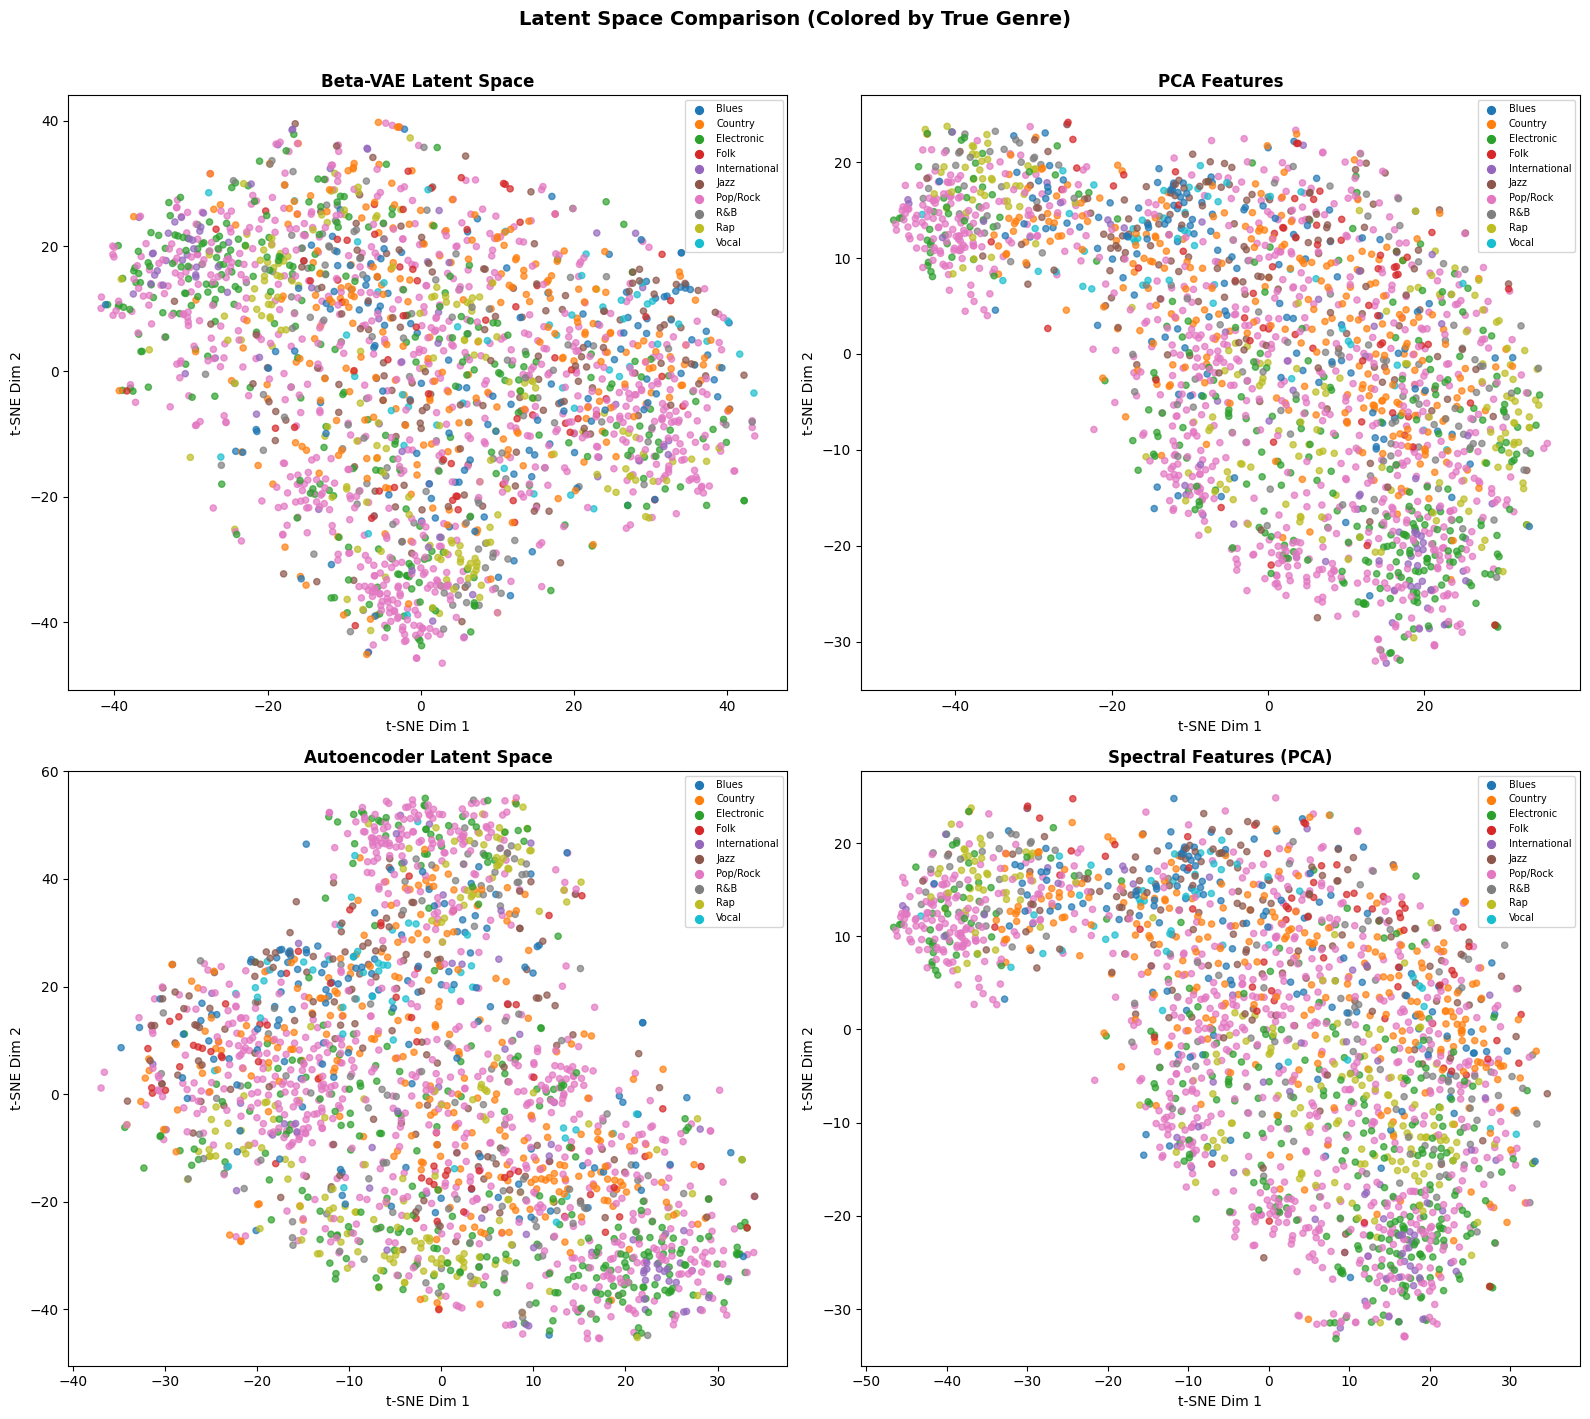

In [25]:
# VISUALIZATION: COMPARE LATENT SPACES

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Helper function for t-SNE and plotting
def tsne_plot(ax, features, labels, title, label_names):
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features)-1))
    features_2d = tsne.fit_transform(features)

    scatter = ax.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.7, s=20)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('t-SNE Dim 1')
    ax.set_ylabel('t-SNE Dim 2')

    # Legend
    unique_labels = np.unique(labels)
    for l in unique_labels:
        mask = labels == l
        ax.scatter([], [], c=plt.cm.tab10(l / 10), label=label_names[l], s=50)
    ax.legend(loc='upper right', fontsize=7, markerscale=0.8)

    return features_2d

# Plot all methods
print("Generating t-SNE visualizations for all methods...")

tsne_plot(axes[0, 0], latent_representations, genre_labels, 'Beta-VAE Latent Space', genre_names)
tsne_plot(axes[0, 1], pca_features, genre_labels, 'PCA Features', genre_names)
tsne_plot(axes[1, 0], ae_latents, genre_labels, 'Autoencoder Latent Space', genre_names)
tsne_plot(axes[1, 1], spectral_pca, genre_labels, 'Spectral Features (PCA)', genre_names)

plt.suptitle('Latent Space Comparison (Colored by True Genre)', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

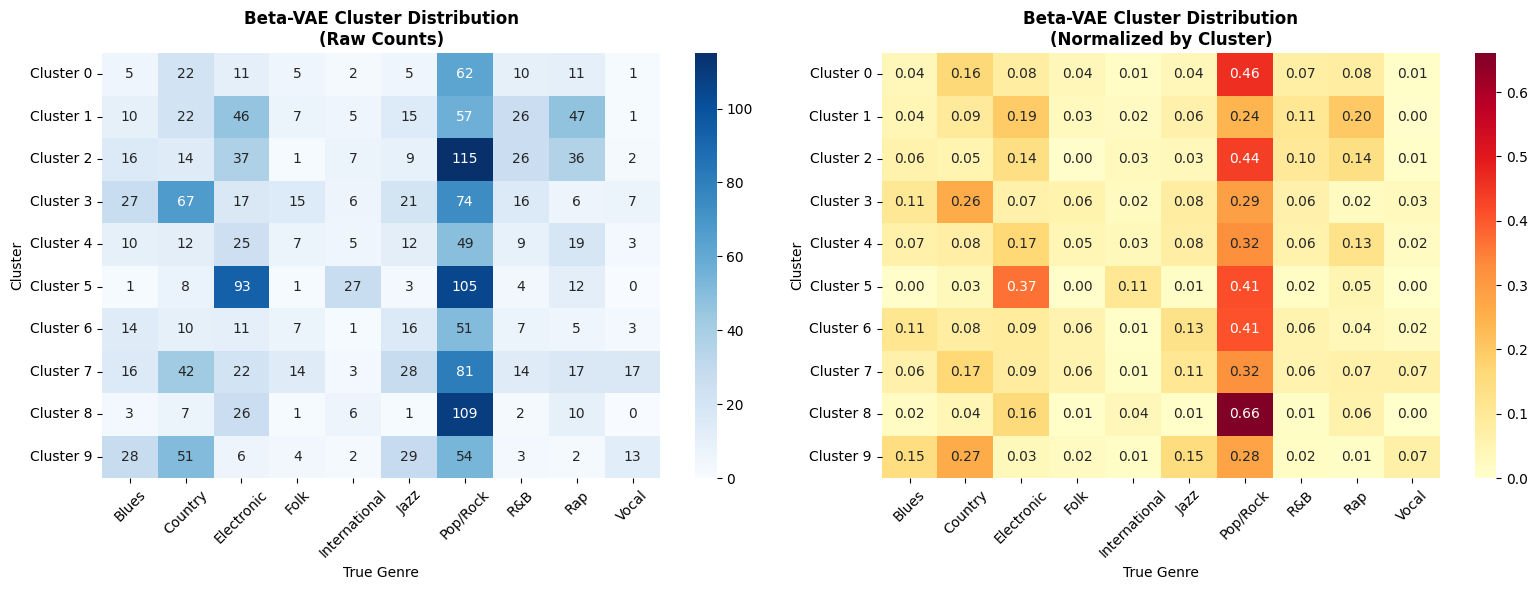

In [26]:
# VISUALIZATION: CLUSTER DISTRIBUTION BY GENRE

def plot_cluster_genre_distribution(cluster_labels, genre_labels, genre_names, title):
    """Plot heatmap showing cluster distribution across genres."""

    n_clusters = len(np.unique(cluster_labels))
    n_genres = len(np.unique(genre_labels))

    # Create confusion matrix (cluster vs genre)
    confusion = np.zeros((n_clusters, n_genres))
    for cluster, genre in zip(cluster_labels, genre_labels):
        confusion[cluster, genre] += 1

    # Normalize by cluster size
    confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Raw counts
    sns.heatmap(confusion.astype(int), annot=True, fmt='d', cmap='Blues',
                xticklabels=genre_names, yticklabels=[f'Cluster {i}' for i in range(n_clusters)],
                ax=axes[0])
    axes[0].set_title(f'{title}\n(Raw Counts)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('True Genre')
    axes[0].set_ylabel('Cluster')
    axes[0].tick_params(axis='x', rotation=45)

    # Normalized (percentage)
    sns.heatmap(confusion_normalized, annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=genre_names, yticklabels=[f'Cluster {i}' for i in range(n_clusters)],
                ax=axes[1])
    axes[1].set_title(f'{title}\n(Normalized by Cluster)', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('True Genre')
    axes[1].set_ylabel('Cluster')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return confusion

# Plot for Beta-VAE
vae_confusion = plot_cluster_genre_distribution(
    vae_cluster_labels, genre_labels, genre_names,
    'Beta-VAE Cluster Distribution'
)

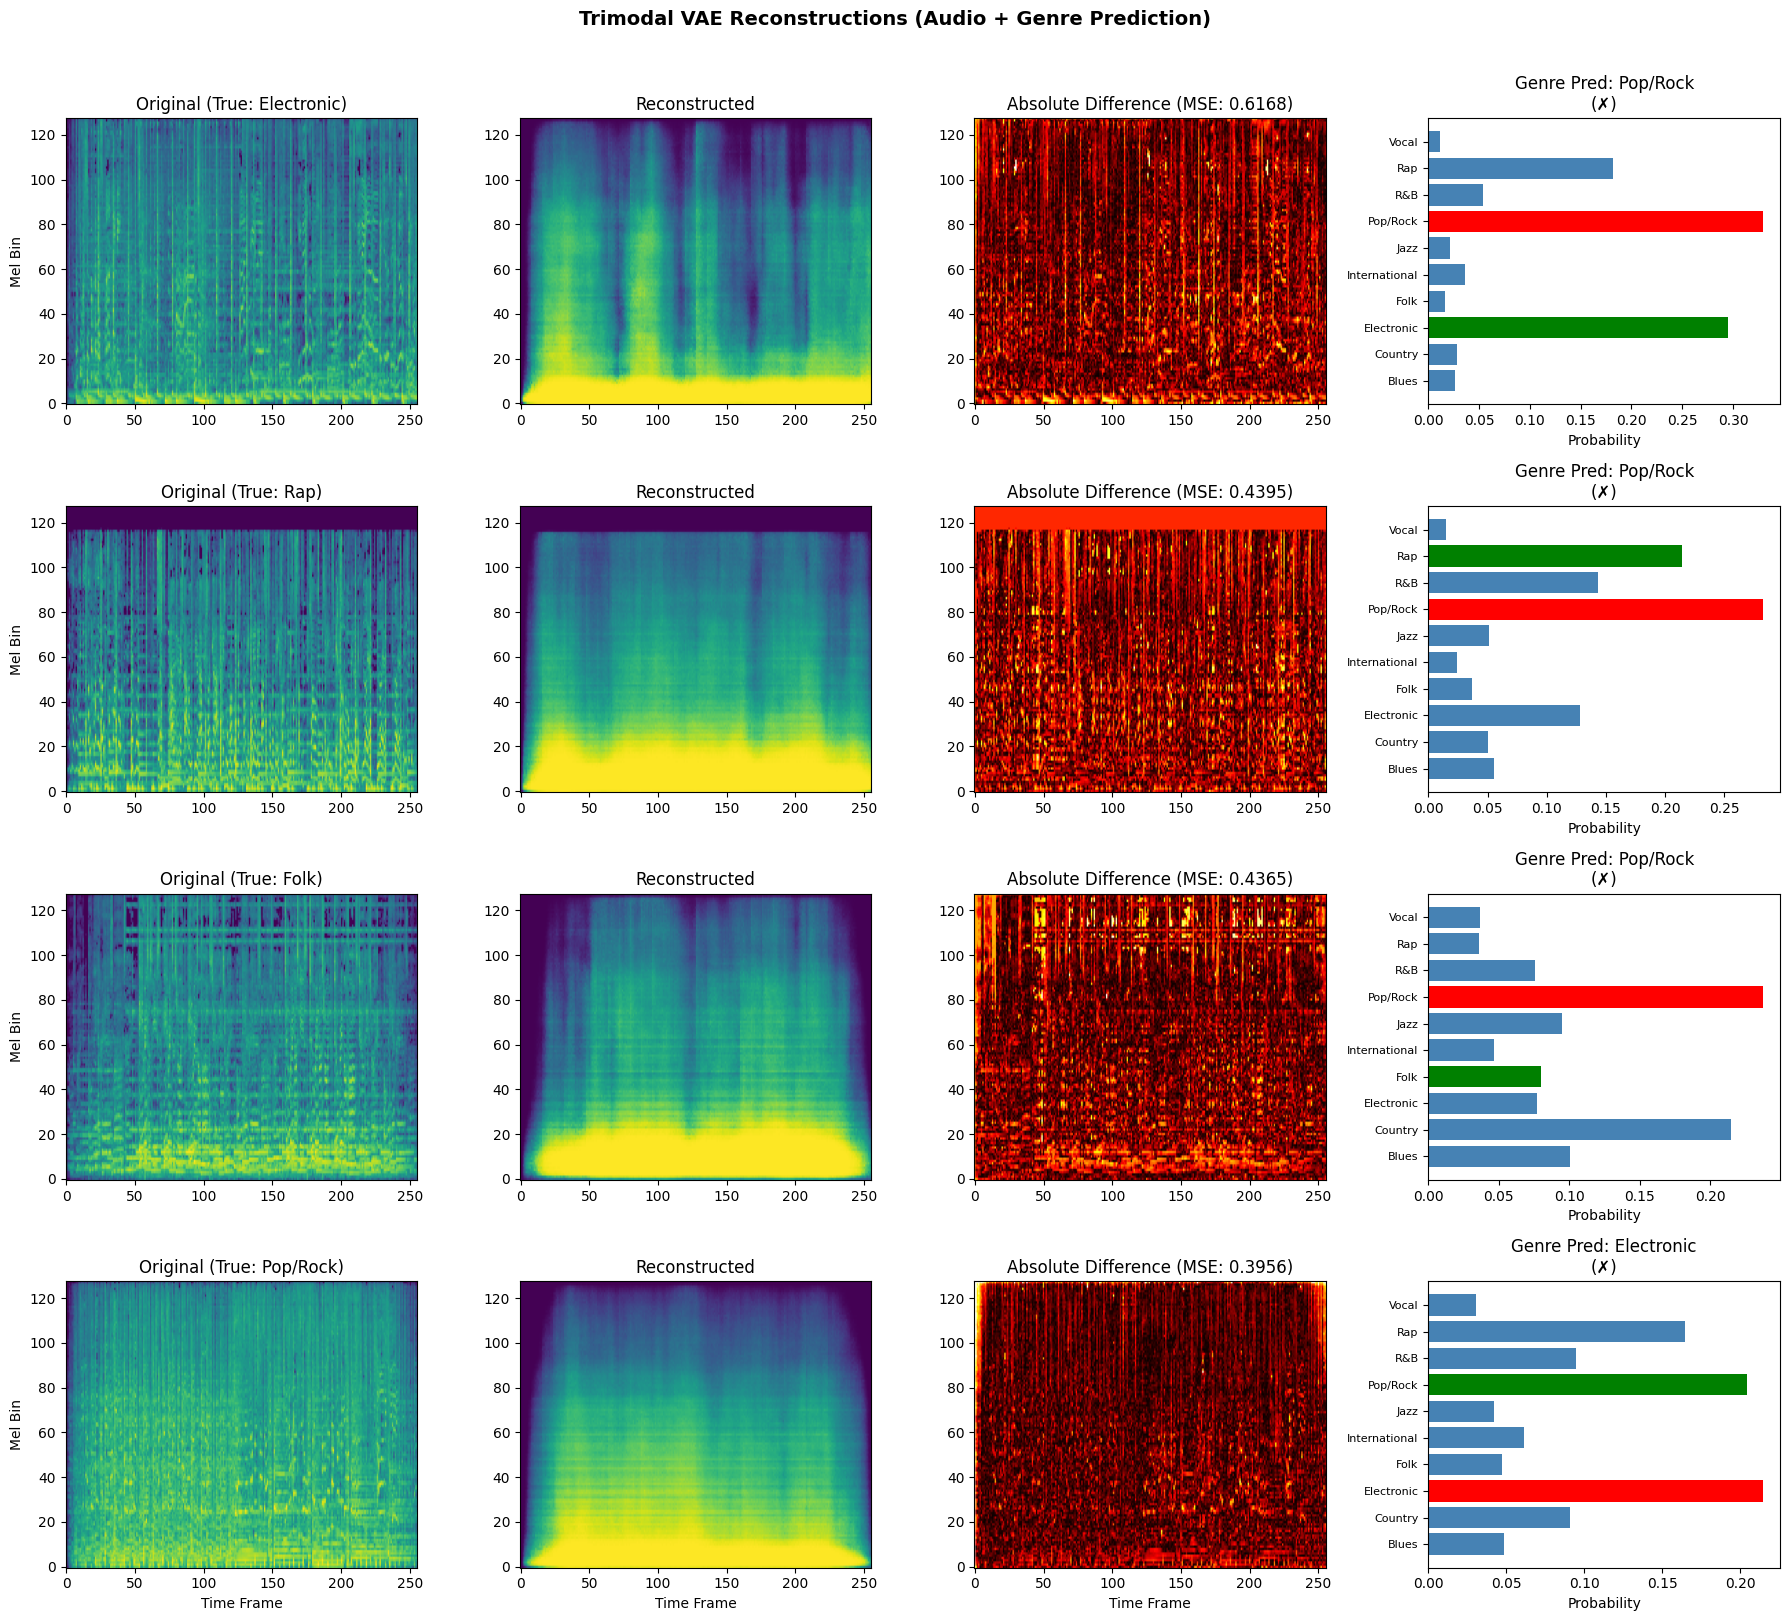

In [27]:
# VISUALIZATION: VAE RECONSTRUCTION EXAMPLES

def visualize_reconstructions(model, dataset, device, n_samples=4):
    """Visualize original vs reconstructed spectrograms and genre predictions."""

    model.eval()

    # Get random samples
    indices = np.random.choice(len(dataset), n_samples, replace=False)

    fig, axes = plt.subplots(n_samples, 4, figsize=(18, 4 * n_samples))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            sample = dataset[idx]
            spectrogram = sample['spectrogram'].unsqueeze(0).to(device)
            lyrics = sample['lyrics'].unsqueeze(0).to(device)
            genre_onehot = sample['genre_onehot'].unsqueeze(0).to(device)
            genre = sample['genre'].item()

            # Get reconstruction (now with genre)
            audio_recon, lyrics_recon, genre_logits, mu, logvar, z = model(spectrogram, lyrics, genre_onehot)

            # Original spectrogram
            orig = spectrogram.squeeze().cpu().numpy()
            recon = audio_recon.squeeze().cpu().numpy()
            diff = np.abs(orig - recon)

            # Genre prediction
            genre_pred = torch.argmax(genre_logits, dim=1).item()
            genre_probs = F.softmax(genre_logits, dim=1).squeeze().cpu().numpy()

            # Plot spectrogram
            axes[i, 0].imshow(orig, aspect='auto', origin='lower', cmap='viridis')
            axes[i, 0].set_title(f'Original (True: {genre_names[genre]})')
            axes[i, 0].set_ylabel('Mel Bin')

            axes[i, 1].imshow(recon, aspect='auto', origin='lower', cmap='viridis')
            axes[i, 1].set_title('Reconstructed')

            axes[i, 2].imshow(diff, aspect='auto', origin='lower', cmap='hot')
            axes[i, 2].set_title(f'Absolute Difference (MSE: {np.mean(diff**2):.4f})')

            # Genre prediction bar chart
            colors = ['green' if j == genre else 'steelblue' for j in range(len(genre_names))]
            colors[genre_pred] = 'red' if genre_pred != genre else 'green'
            axes[i, 3].barh(range(len(genre_names)), genre_probs, color=colors)
            axes[i, 3].set_yticks(range(len(genre_names)))
            axes[i, 3].set_yticklabels(genre_names, fontsize=8)
            axes[i, 3].set_xlabel('Probability')
            axes[i, 3].set_title(f'Genre Pred: {genre_names[genre_pred]}\n({"✓" if genre_pred == genre else "✗"})')


    for ax in axes[-1, :3]:
        ax.set_xlabel('Time Frame')

    plt.suptitle('Trimodal VAE Reconstructions (Audio + Genre Prediction)', fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()

# Visualize reconstructions
visualize_reconstructions(model, dataset, device, n_samples=4)

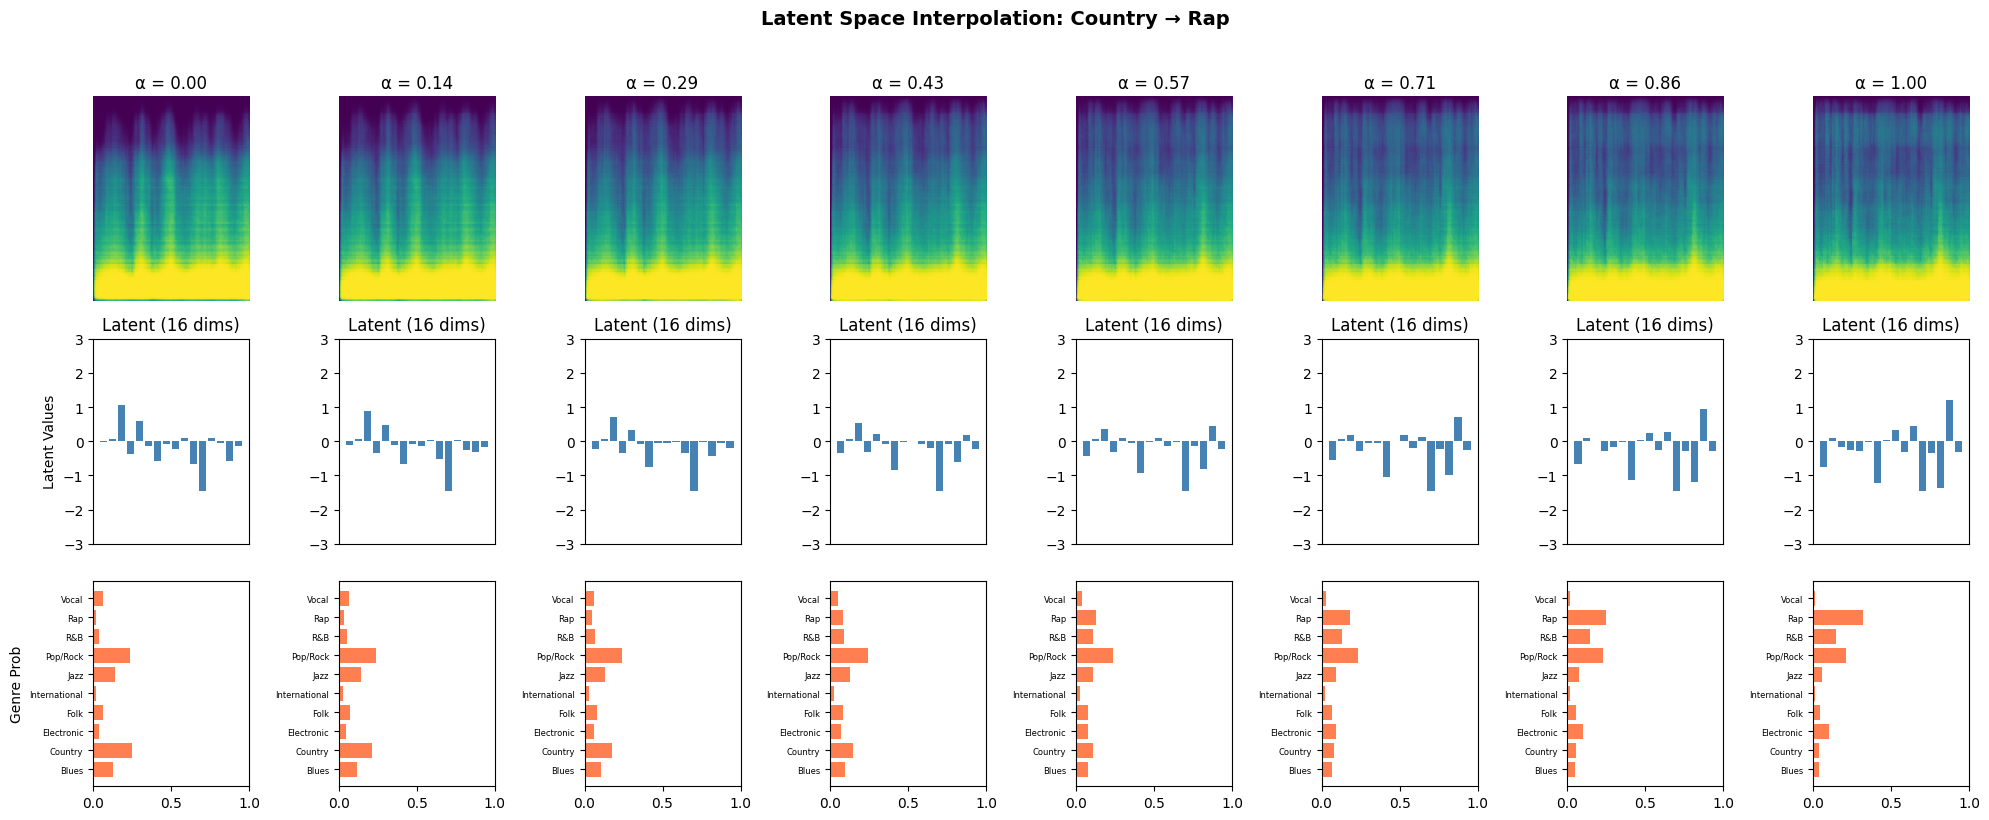

In [28]:
# ============================================
# 18. VISUALIZATION: LATENT SPACE INTERPOLATION
# ============================================

def latent_interpolation(model, dataset, device, genre_names, n_steps=8):
    """Visualize interpolation between two samples in latent space."""

    model.eval()

    # Select two random samples from different genres
    unique_genres = np.unique(genre_labels)
    if len(unique_genres) >= 2:
        genre1, genre2 = np.random.choice(unique_genres, 2, replace=False)
    else:
        genre1 = genre2 = unique_genres[0]

    # Find samples for each genre
    idx1 = np.where(genre_labels == genre1)[0][0]
    idx2 = np.where(genre_labels == genre2)[0][0]

    sample1 = dataset[idx1]
    sample2 = dataset[idx2]

    with torch.no_grad():
        # Get latent representations (with genre_onehot)
        spec1 = sample1['spectrogram'].unsqueeze(0).to(device)
        lyrics1 = sample1['lyrics'].unsqueeze(0).to(device)
        genre_oh1 = sample1['genre_onehot'].unsqueeze(0).to(device)
        z1 = model.get_latent(spec1, lyrics1, genre_oh1)

        spec2 = sample2['spectrogram'].unsqueeze(0).to(device)
        lyrics2 = sample2['lyrics'].unsqueeze(0).to(device)
        genre_oh2 = sample2['genre_onehot'].unsqueeze(0).to(device)
        z2 = model.get_latent(spec2, lyrics2, genre_oh2)

        # Interpolate
        fig, axes = plt.subplots(3, n_steps, figsize=(20, 8))

        for i, alpha in enumerate(np.linspace(0, 1, n_steps)):
            z_interp = (1 - alpha) * z1 + alpha * z2
            audio_recon, lyrics_recon, genre_logits = model.decode(z_interp)
            recon = audio_recon.squeeze().cpu().numpy()

            # Spectrogram
            axes[0, i].imshow(recon, aspect='auto', origin='lower', cmap='viridis')
            axes[0, i].set_title(f'α = {alpha:.2f}')
            axes[0, i].axis('off')

            # Latent values (first 16 dims)
            z_vals = z_interp.squeeze().cpu().numpy()[:16]
            axes[1, i].bar(range(len(z_vals)), z_vals, color='steelblue')
            axes[1, i].set_ylim(-3, 3)
            axes[1, i].set_title('Latent (16 dims)')
            axes[1, i].set_xticks([])

            # Genre prediction
            genre_probs = F.softmax(genre_logits, dim=1).squeeze().cpu().numpy()
            axes[2, i].barh(range(len(genre_names)), genre_probs, color='coral')
            axes[2, i].set_yticks(range(len(genre_names)))
            axes[2, i].set_yticklabels(genre_names, fontsize=6)
            axes[2, i].set_xlim(0, 1)

        axes[0, 0].set_ylabel('Spectrogram')
        axes[1, 0].set_ylabel('Latent Values')
        axes[2, 0].set_ylabel('Genre Prob')

        plt.suptitle(f'Latent Space Interpolation: {genre_names[genre1]} → {genre_names[genre2]}',
                     fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

# Perform interpolation
latent_interpolation(model, dataset, device, genre_names)


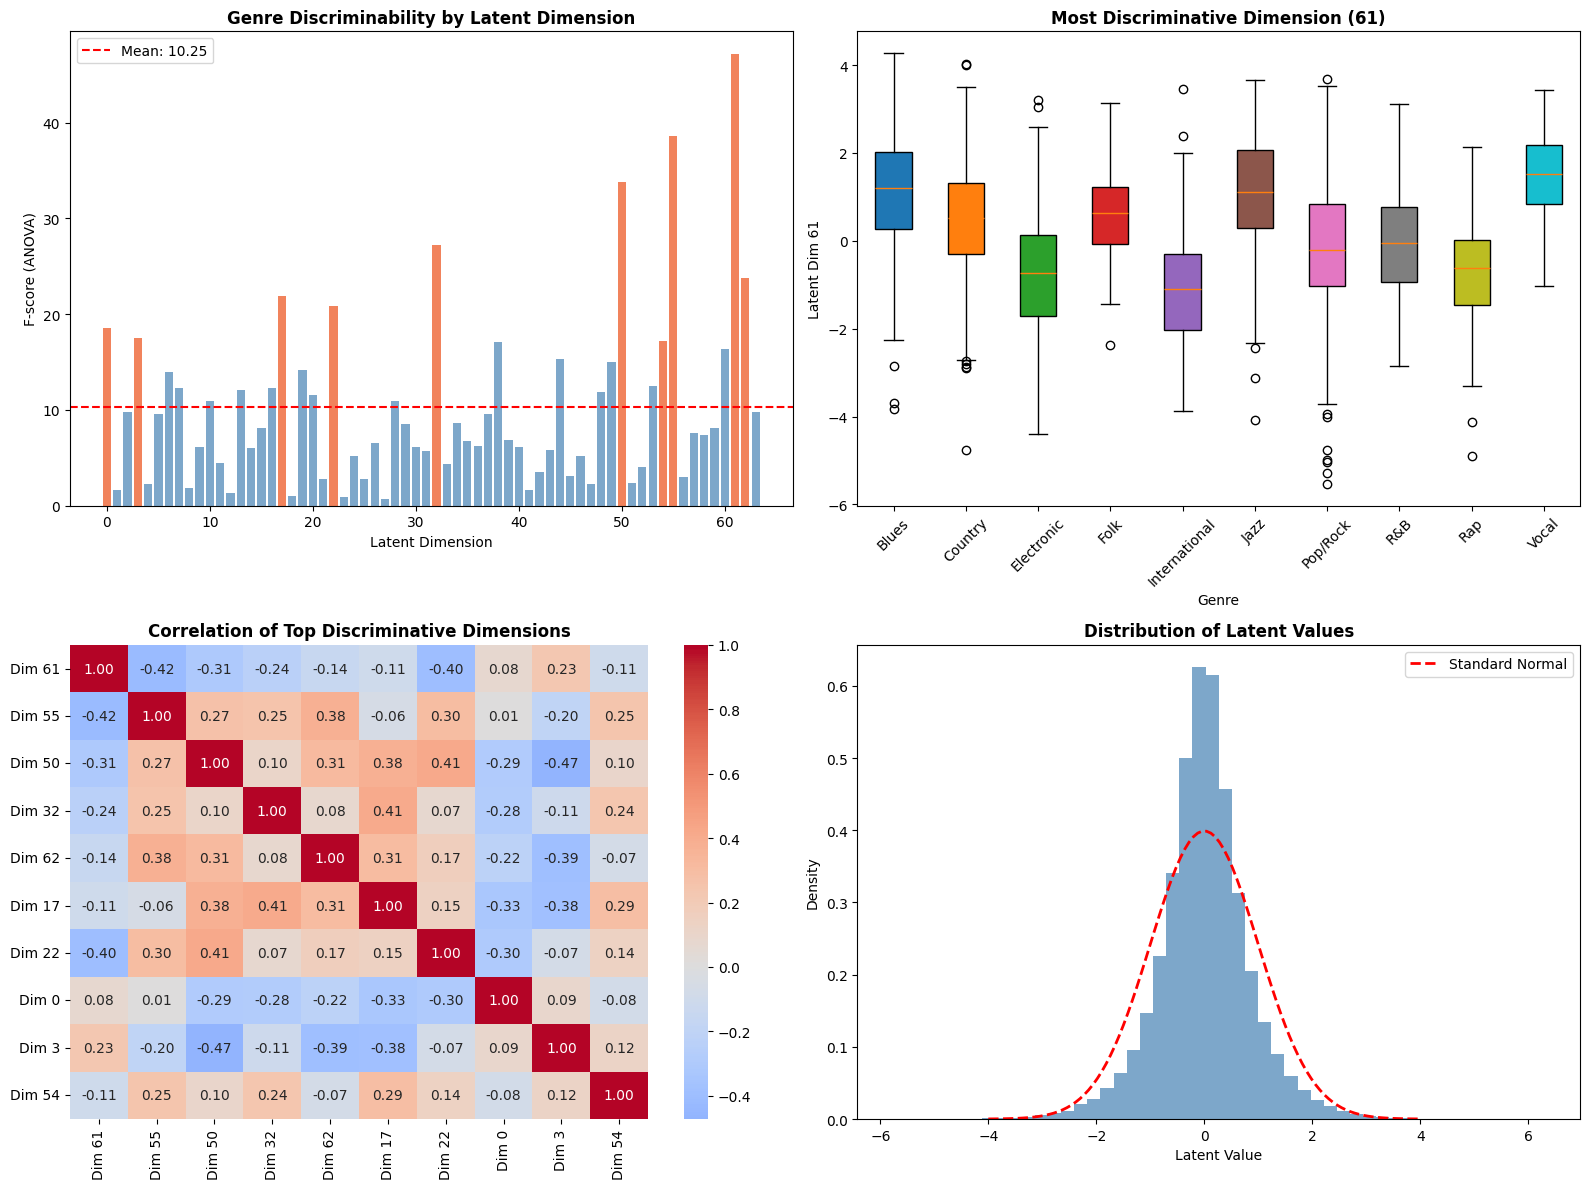


📊 Top 10 most discriminative latent dimensions:
  1. Dimension 61: F-score = 47.18, p-value = 0.00e+00
  2. Dimension 55: F-score = 38.61, p-value = 0.00e+00
  3. Dimension 50: F-score = 33.79, p-value = 0.00e+00
  4. Dimension 32: F-score = 27.20, p-value = 8.41e-45
  5. Dimension 62: F-score = 23.76, p-value = 5.87e-39
  6. Dimension 17: F-score = 21.92, p-value = 8.14e-36
  7. Dimension 22: F-score = 20.87, p-value = 5.37e-34
  8. Dimension 0: F-score = 18.52, p-value = 5.96e-30
  9. Dimension 3: F-score = 17.50, p-value = 3.51e-28
  10. Dimension 54: F-score = 17.17, p-value = 1.30e-27


In [29]:
# VISUALIZATION: LATENT DIMENSION ANALYSIS

def analyze_latent_dimensions(latent_representations, genre_labels, genre_names, n_top_dims=10):
    """Analyze which latent dimensions are most discriminative for genres."""

    # Calculate variance explained by genre for each dimension
    from scipy.stats import f_oneway

    f_scores = []
    p_values = []

    for dim in range(latent_representations.shape[1]):
        groups = [latent_representations[genre_labels == g, dim] for g in np.unique(genre_labels)]
        f_stat, p_val = f_oneway(*groups)
        f_scores.append(f_stat)
        p_values.append(p_val)

    f_scores = np.array(f_scores)
    p_values = np.array(p_values)

    # Top discriminative dimensions
    top_dims = np.argsort(f_scores)[::-1][:n_top_dims]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: F-scores for all dimensions
    axes[0, 0].bar(range(len(f_scores)), f_scores, color='steelblue', alpha=0.7)
    axes[0, 0].bar(top_dims, f_scores[top_dims], color='coral', alpha=0.9)
    axes[0, 0].set_xlabel('Latent Dimension')
    axes[0, 0].set_ylabel('F-score (ANOVA)')
    axes[0, 0].set_title('Genre Discriminability by Latent Dimension', fontweight='bold')
    axes[0, 0].axhline(y=np.mean(f_scores), color='red', linestyle='--', label=f'Mean: {np.mean(f_scores):.2f}')
    axes[0, 0].legend()

    # Plot 2: Box plots for top discriminative dimensions
    top_dim = top_dims[0]
    data_for_box = [latent_representations[genre_labels == g, top_dim] for g in np.unique(genre_labels)]
    bp = axes[0, 1].boxplot(data_for_box, labels=genre_names, patch_artist=True)
    colors_bp = plt.cm.tab10(np.linspace(0, 1, len(genre_names)))
    for patch, color in zip(bp['boxes'], colors_bp):
        patch.set_facecolor(color)
    axes[0, 1].set_xlabel('Genre')
    axes[0, 1].set_ylabel(f'Latent Dim {top_dim}')
    axes[0, 1].set_title(f'Most Discriminative Dimension ({top_dim})', fontweight='bold')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Plot 3: Correlation heatmap of top dimensions
    top_latents = latent_representations[:, top_dims]
    corr_matrix = np.corrcoef(top_latents.T)
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                xticklabels=[f'Dim {d}' for d in top_dims],
                yticklabels=[f'Dim {d}' for d in top_dims],
                ax=axes[1, 0])
    axes[1, 0].set_title('Correlation of Top Discriminative Dimensions', fontweight='bold')

    # Plot 4: Distribution of latent dimension values
    axes[1, 1].hist(latent_representations.flatten(), bins=50, density=True, alpha=0.7, color='steelblue')
    axes[1, 1].set_xlabel('Latent Value')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].set_title('Distribution of Latent Values', fontweight='bold')

    # Overlay Gaussian
    from scipy.stats import norm
    x = np.linspace(-4, 4, 100)
    axes[1, 1].plot(x, norm.pdf(x, 0, 1), 'r--', linewidth=2, label='Standard Normal')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    print(f"\n📊 Top {n_top_dims} most discriminative latent dimensions:")
    for i, dim in enumerate(top_dims):
        print(f"  {i+1}. Dimension {dim}: F-score = {f_scores[dim]:.2f}, p-value = {p_values[dim]:.2e}")

# Analyze latent dimensions
analyze_latent_dimensions(latent_representations, genre_labels, genre_names)